In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from tqdm import tqdm

In [2]:
def splitdata(data,i): # split according to the recursive evaluation
    train = data[data['DATE'] < i]
    val = data.loc[train.shape[0]:]
    val = val[val['DATE']<i+120000]   
    
    test = data.loc[(train.shape[0]+val.shape[0]):]
    test = test[test['DATE'] < i+130000]
    
    #set x_train, y_train, x_val, y_val, x_test and y_test
    x_train=np.array(train.drop(['DATE', 'RET','permno'],axis=1))
    y_train=np.array(train['RET']) 
    x_val=np.array(val.drop(['DATE', 'RET','permno'],axis=1))
    y_val=np.array(val['RET'])
    x_test=np.array(test.drop(['DATE', 'RET','permno'],axis=1))
    y_test=np.array(test['RET'])
    
    return x_train,y_train,x_val,y_val,x_test,y_test

In [3]:
def downcast(df): # change the datatype of dataframe to save memory
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df 

In [4]:
def calculate_R_square(y_true, pre_ret): # new R2 according to the paper
    a = ((y_true-pre_ret)**2).sum()
    b = (y_true**2).sum()
    R_square = 1-(a/b)
    return R_square

In [53]:
df=pd.read_csv('preprocessed_bottom_data.csv')

In [54]:
df=downcast(df)

In [108]:
R_square=[]
all_depth=[]

for i in tqdm(range(19750100,20040100,10000)):

    x_train,y_train,x_val,y_val,x_test,y_test=splitdata(df,i)

    bestRSqr = float("-Inf")
    bestGbrt = None
    bestDepth=0

    for depth in [1,2,3,4]: # change the depth of the sub model in gbr
        gbrt = GBR(max_depth=depth,n_estimators=7,loss='huber')
        gbrt.fit(x_train,y_train)
        pred = gbrt.predict(x_val)
        currentRSqr = calculate_R_square(y_val, pred)

        if(currentRSqr>bestRSqr): # get the model with the best validation dataset performance
            bestRSqr=currentRSqr
            bestGbrt=gbrt
            bestDepth=depth        

    resultPred = bestGbrt.predict(x_test) # use to predict
    resultRSqr = calculate_R_square(y_test, resultPred)
    R_square.append(resultRSqr)
    all_depth.append(bestDepth)
    

100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [53:51<00:00, 111.43s/it]


In [83]:
importance=bestGbrt.feature_importances_
col=df.drop(['DATE', 'RET','permno'],axis=1).columns
diction=dict(zip(col,importance))
diction=sorted(diction.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
diction=dict(diction[0:20])
x=list(diction.keys())
y=list(diction.values())

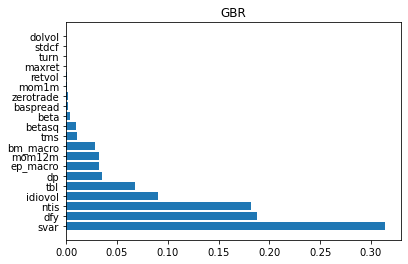

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.title("GBR") # feature importance
plt.barh(x,y)
plt.show()

C:\Users\ufo\anaconda3\envs\tensorflow1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


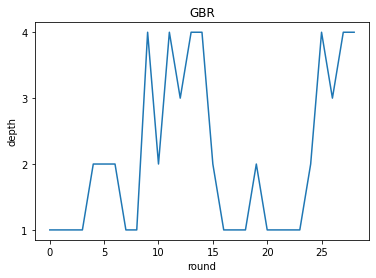

In [87]:
sns.lineplot(range(29),all_depth) # parameter tuning
plt.title("GBR")
plt.ylabel("depth")
plt.xlabel("round")
plt.yticks(np.linspace(1,4,4))
plt.show()

In [56]:
R_square_rf=[]
all_depth_rf=[]

for i in tqdm(range(19750100,20040100,10000)):

    x_train,y_train,x_val,y_val,x_test,y_test=splitdata(df,i)

    bestRSqr = float("-Inf")
    bestRFR = None
    bestDepth=0

    for depth in [1,2,3,4,5]:
        rfr = RFR(max_depth=depth,n_estimators=8)
        rfr.fit(x_train,y_train)
        pred = rfr.predict(x_val)
        currentRSqr = calculate_R_square(y_val, pred)

        if(currentRSqr>bestRSqr):
            bestRSqr=currentRSqr
            bestRFR=rfr
            bestDepth=depth        
    resultPred = bestRFR.predict(x_test)
    resultRSqr = calculate_R_square(y_test, resultPred)
    R_square_rf.append(resultRSqr)
    all_depth_rf.append(bestDepth)

100%|███████████████████████████████████████████████████████████████████████████████| 29/29 [1:04:27<00:00, 133.37s/it]


In [11]:
importance_rf=bestRFR.feature_importances_

In [38]:
col=df.drop(['DATE', 'RET','permno'],axis=1).columns
diction=dict(zip(col,importance_rf))
diction=sorted(diction.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
diction=dict(diction[0:20])
x_r=list(diction.keys())
y_r=list(diction.values())

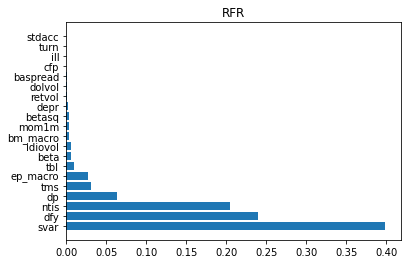

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.title("RFR")
plt.barh(x_r,y_r)
plt.show()

C:\Users\ufo\anaconda3\envs\tensorflow1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


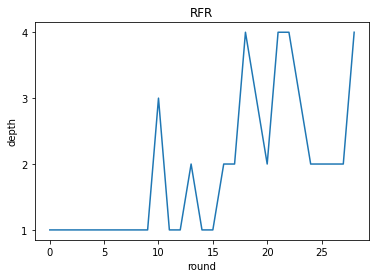

In [17]:
sns.lineplot(range(29),all_depth_rf)
plt.title("RFR")
plt.ylabel("depth")
plt.xlabel("round")
plt.yticks(np.linspace(1,4,4))
plt.show()